# Kanji Recognizer


by Aiyu Kamate
https://towardsdatascience.com/creating-a-japanese-handwriting-recognizer-70be12732889

##Installing all depenendencies needed
1. Python 3.X (any python3 version should work)
2. Tensorflow 2.2.0
3. Keras 2.4.3
4. Numpy 1.16.4
6. matplotlib — newest version
7. PIL — newest version
8. skimage — newest version
9. sklearn — newest version
10. corelmltools 3.2



### Check python version

In [ ]:
!python --version

Python 3.6.9


### Install dependencies

In [ ]:
!pip install tensorflow==2.2.0
!pip install keras==2.4.3
!pip install numpy
!pip install matplotlib
!pip install Pillow
!pip install scikit-image
!pip install sklearn
!pip install coremltools==3.2

## Preprocessing

### Reading dataset

Reading Kanji characteres to compress it on a numpy compressed file to make it more flexible to use.

In [ ]:
import struct, os
from PIL import Image
import numpy as np

# Hiragana character to be excluded
label = ["あ", "い", "う", "え", "お", "か", "が",  "き", "ぎ",
         "く", "ぐ", "け", "げ", "こ", "ご", "さ", "ざ", "し",
         "じ", "す", "ず", "せ", "ぜ", "そ", "ぞ", "た", "だ",
         "ち", "ぢ", "つ", "づ", "て", "で", "と", "ど", "な",
         "に", "ぬ", "ね", "の", "は", "ば", "ぱ", "ひ", "び",
         "ぴ", "ふ", "ぶ", "ぷ", "へ", "べ", "ぺ", "ほ", "ぼ",
         "ぽ", "ま", "み", "む", "め", "も", "や", "ゆ", "よ",
         "ら", "り", "る", "れ", "ろ", "わ", "を", "ん", "っ",
         "ゃ", "ゅ", "ょ"]

def string_unicode_to_han(unicode):
    han_unicode = '\\u{}'.format(unicode)
    return han_unicode.encode('ascii').decode('unicode-escape')

def file_path_narray(filepath):
    im = Image.open(filepath)
    return im.convert('L')

def read_kanji():
    """
    881 - kanji excluding hiragana characters
    161 - images by writers
    127 - width
    128 - height
    """
    kanji = np.zeros([881, 161, 127, 128], dtype=np.uint8) 
    foldername = "../dataset/ETL8G/"
    i = 0
    print("Reading images...")
    for folder in os.scandir(foldername):
        # Decode unicode to han character
        han_char = string_unicode_to_han(folder.name[2:])

        if(han_char not in label):
            j = 0
            for file in os.scandir(folder.path):
                if file.name != ".char.txt":
                    # Convert file to Pillow image and then to numpy array
                    iL = file_path_narray(file.path)
                    kanji[i, j] =  np.array(iL)
                    j += 1
            i += 1
    print("Finished reading images")
    # Finish compressing kanji dataset
    print("Compressing images...")
    np.savez_compressed("kanji.npz", kanji)
    print("Finished compressing")

In [ ]:
read_kanji()

### Converting data to training and test labels/images

In [ ]:
import skimage.transform
import numpy as np
from sklearn.model_selection import train_test_split

kanji = 881
rows = 48
cols = 48

kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

train_images = np.zeros([kanji * 160, rows, cols], dtype=np.float32)

arr = np.arange(kanji)
train_labels = np.repeat(arr, 160)

# Decompressing
print("Decompressing...")
for i in range( (kanji) * 160):
	if int(i/160) != 88 and int(i/160) != 219 and int(i/160) != 349 and int(i/160) != 457:
		if int(i/160) < 88:
			train_images[i] = skimage.transform.resize(kan[i], (rows, cols))
		if int(i/160) > 88 and int(i/160) < 219:
			train_images[i-160] = skimage.transform.resize(kan[i], (rows, cols))
		if int(i/160) > 219 and int(i/160) < 349:
			train_images[i-320] = skimage.transform.resize(kan[i], (rows, cols))
		if int(i/160) > 349 and int(i/160) < 457:
			train_images[i-480] = skimage.transform.resize(kan[i], (rows, cols))
		if int(i/160) > 457:
			train_images[i-640] = skimage.transform.resize(kan[i], (rows, cols))
      
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.2)
print("Finished decompressing")

print("Initializating compresion...")
np.savez_compressed("kanji_train_images.npz", train_images)
np.savez_compressed("kanji_train_labels.npz", train_labels)
np.savez_compressed("kanji_test_images.npz", test_images)
np.savez_compressed("kanji_test_labels.npz", test_labels)
print("Finished compresion")

### Visualizing training images

Starting visualization


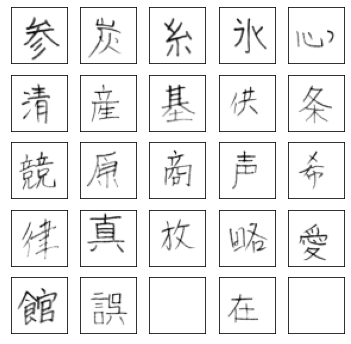

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

kanjis = np.load("kanji_train_images.npz")['arr_0'].astype(np.float32)

print("Starting visualization")
plt.figure(figsize=(6,6)).patch.set_facecolor('#ffffff')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(kanjis[i], cmap=plt.cm.binary)
plt.show()

## Model

### Model training

Kanji model training with CNN with the following layer:
- Covolution2D: ReLU
- MaxPooling2D
- Flatten
- Dropout
- Dense: ReLU
- Dense: softmax

In [ ]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_images = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']
test_images = np.load("kanji_test_images.npz")['arr_0']
test_labels = np.load("kanji_test_labels.npz")['arr_0']

# Images data in ML are represented as 3d arrays:
# - width (columns)
# - Height (rows)
# - Color (channels)
# Channels first represent that the channel is the first position
# in the 3d array
# Channels last represent that the channel is the last position in
# the 3d array 
if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1, 48, 48)
  test_images = test_images.reshape(test_images.shape[0], 1, 48, 48)
  shape = (1, 48, 48)
else:
  train_images = train_images.reshape(train_images.shape[0], 48, 48, 1)
  test_images = test_images.reshape(test_images.shape[0], 48, 48, 1)
  shape = (48, 48, 1)

# Set image modification parameter:
# Rotation: 15 degree
# Zoom: 120%  
datagen = ImageDataGenerator(rotation_range=15,zoom_range=0.2)
datagen.fit(train_images)
# Create model
model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(881, activation="softmax")
])

#model.summary()

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
              
model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

#test_loss, test_acc = model.evaluate(test_images, test_labels)
#print("Test Accuracy: ", test_acc)

model.save("kanji.h5")

### Model review

Load model

In [ ]:
model = keras.models.load_model("kanji.h5")

Seeing the summary of the model

In [ ]:
model.summary()

Evaluating the model

In [ ]:
# Load test dataset for the evaluation
test_images = np.load("kanji_test_images.npz")['arr_0']
test_labels = np.load("kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  test_images = test_images.reshape(test_images.shape[0], 1, 48, 48)
  shape = (1, 48, 48)
else:
  test_images = test_images.reshape(test_images.shape[0], 48, 48, 1)
  shape = (48, 48, 1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss) 
print("Test Accuracy: ", test_acc)